# Visalising the Cyclone Data: Plotting cyclone tracks

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

# Setting default figure size and default inline image format
plt.rcParams['figure.figsize'] = (12,7)
%config InlineBackend.figure_formats = ['svg']
# Trigering interactive inline mode to store and display outputs within the notebook whenever they are modified
%matplotlib inline 

In [2]:
# Reading data
url = 'GBR_cyclones.csv'
GBR_cyclones = pd.read_csv(url, parse_dates=['ISO_TIME'], usecols=range(13), index_col='SID',
                 skiprows=[1], na_values=' ',
                 keep_default_na=False, dtype={'NAME': str})
GBR_cyclones

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,CATEGORY
SID,,,,,,,,,,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-22 15:00:00,NR,-15.5881,147.218,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-22 18:00:00,TS,-15.5000,147.800,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-22 21:00:00,TS,-15.4618,148.348,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 00:00:00,TS,-15.4600,148.980,30.0,997.0,tropical depression
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 03:00:00,TS,-15.5585,149.895,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0,tropical storm
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 09:00:00,NR,-41.8348,165.489,,,
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 12:00:00,NR,-42.3000,165.400,40.0,984.0,tropical storm


We will create a dataset without the NaN values so that we can choose whether to show or hide NaN values in our plots.   
First, we check the data type of each of our columns:

In [3]:
GBR_cyclones.dtypes

SEASON               int64
NUMBER               int64
BASIN               object
SUBBASIN            object
NAME                object
ISO_TIME    datetime64[ns]
NATURE              object
LAT                float64
LON                float64
WMO_WIND            object
WMO_PRES            object
CATEGORY            object
dtype: object

In [4]:
# Assigning a new variable name to create a copy of the dataframe that we can manipulate
GBR_notna = GBR_cyclones
# NaNs are floating point values. As the data type for WMO_WIND is an object, 
# we need to convert it to float64 data type so they are recognised as NaNs:
GBR_notna['WMO_WIND'] = pd.to_numeric(GBR_notna['WMO_WIND'], errors='coerce')
# Removing NaN values
GBR_notna = GBR_notna[GBR_notna["WMO_WIND"].notna()]
GBR_notna

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,CATEGORY
SID,,,,,,,,,,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 00:00:00,TS,-15.4600,148.980,30.0,997.0,tropical depression
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 06:00:00,TS,-15.7571,150.943,40.0,990.0,tropical storm
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 12:00:00,TS,-16.4000,153.150,45.0,990.0,tropical storm
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 18:00:00,TS,-16.9500,155.100,35.0,993.0,tropical storm
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-24 00:00:00,TS,-17.5500,156.600,30.0,998.0,tropical depression
...,...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-17 18:00:00,NR,-39.8000,168.200,40.0,979.0,tropical storm
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 00:00:00,NR,-40.5000,166.500,40.0,982.0,tropical storm
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0,tropical storm


Now we will define a function that extracts only the time of impact (ISO_TIME), lat and lon values, and cyclone category for the specified cyclone:

In [5]:
def cycData(cycName, NaN=False):
    # Specifying columns we don't need by index number
    cols = [0, 1, 2, 3, 4, 6, 9, 10]
    
    # Converts the string of the cyclone name into upper case which is the format the names are in in the dataframe
    cycNameUpper = cycName.upper()
    
    if NaN==False:
        # Extracting specified cyclone data, dropping specified columns and setting the index to time
        df_cycName = GBR_notna[GBR_notna["NAME"].str.contains(cycNameUpper) == True].drop(GBR_notna.columns[cols],
                                                                                          axis=1) 
            # axis=1 indicates we are dropping from the columns rather than the index
    else:
        # Extracting specified cyclone data, dropping specified columns and setting the index to time
        df_cycName = GBR_cyclones[GBR_cyclones["NAME"].str.contains(cycNameUpper) == True].drop(GBR_cyclones.columns[cols],
                                                                                          axis=1) 
        # axis=1 indicates we are dropping from the columns rather than the index

    return df_cycName

# Calling the function
Ita = cycData('Ita')
Anthony = cycData('Anthony')
Dylan = cycData('Dylan')
Oswald = cycData('Oswald', NaN=True) # NaN values are kept for Oswald as much of its wind speed values are unknown
Hadi = cycData('Hadi')
Jasmine = cycData('Jasmine')
Sandra = cycData('Sandra')
Tim = cycData('Tim')
Yasi = cycData('Yasi')

Next, we will define a plotting function to visualise cyclone movement:

In [6]:
def cycPlot(data, mapRange, cycName, cityalign='right', cityoffset=-10, timeoffset=10, timePlot_interval=1, timePlot=False):
    
    '''
    This function plots the path of a specified cyclone within a specified map range
    
    args:
    - data: pandas cyclone data, e.g. Ita
    - mapRange: site name for lat/lon range of the basemap, e.g. QLD coast
    - cycName: name of the cyclone, e.g. Ita
    - cityalign: horizontal alignment of the city name annotations. Default right aligned.
    - cityoffset:horizontal offset of city name annotation from marker. Default -10.
    - timeoffset: horizontal offset of timestamps from markers. Default 10. 
    - timePlot_interval: specifies the interval for the timeplot. Plots all by default.
    - timePlot: shows or hides the timestamps corresponding to recorded cyclone lat/lon points    
    '''

    plt.style.use('seaborn-white')

    # Creating cyclone category colour key
    colors = {'NaN': 'grey', '': 'grey','tropical depression': '#ffe5e5', 'tropical storm': '#ffcccc', 'category 1': '#ffb2b2', 
              'category 2': '#ff9999', 'category 3': '#ff7f7f', 'category 4': '#ff6666', 'category 5': '#ff4c4c'}

    # Create bay range dataframe with site names and long-lat ranges
    bayRange = {
        'site': ['QLD coast', 'Cairns', 'Hervey Bay', 'Moreton Bay', 'Townsville', 'Cairns to Townsville', 
                 'Hervey Bay to Moreton Bay'],
        'llcrnrlon' : [143.0, 145.318788, 152.308788, 153.028788, 146.308788, 145, 152],
        'urcrnrlon' : [160.0, 146.278788, 153.298788, 153.988788, 147.298788, 147.5, 154],
        'llcrnrlat' : [-30.0, -17.386022, -25.786022, -27.796022, -19.786022, -19.8, -27.8],
        'urcrnrlat' : [-10.0, -16.426022, -24.826022, -26.806022, -18.826022, -16.6, -24.8]
        }

    bayRange_df = pd.DataFrame(bayRange, columns = ['site', 'llcrnrlon', 'urcrnrlon', 'llcrnrlat', 'urcrnrlat']).set_index('site')

    # Create cities dataframe with names and locations
    cities = {
        'city': ['Cairns', 'Hervey Bay', 'Moreton Bay', 'Townsville'],
        'lon': [145.7710, 152.7677, 152.9206, 146.8169],
        'lat': [-16.9203,-25.2882, -27.0946, -19.2590]
        }

    cities_df = pd.DataFrame(cities, columns = ['city', 'lon', 'lat'])


    fig, ax = plt.subplots(1, 1, figsize=(7, 9))

    # Adding basemap of specified map range underneath cyclone path plot
    llcrnrlon = bayRange_df.loc[[mapRange], ['llcrnrlon']].values[0]
    llcrnrlat = bayRange_df.loc[[mapRange], ['llcrnrlat']].values[0]
    urcrnrlon = bayRange_df.loc[[mapRange], ['urcrnrlon']].values[0]
    urcrnrlat = bayRange_df.loc[[mapRange], ['urcrnrlat']].values[0]
        
    m = Basemap(llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat, resolution = 'i', projection = 'merc')
    m.drawmapboundary(fill_color='white', linewidth=0)
    m.fillcontinents(color='#D9D9D9', alpha=0.7)
    m.drawcoastlines(linewidth=0.1, color="white")

    # Plotting category markers with specified colour key
    data['x'], data['y'] = m(data['LON'], data['LAT'])

    for CATEGORY in list(data['CATEGORY'].unique()):
        ax.scatter(data[data['CATEGORY'] == CATEGORY]['x'],
                   data[data['CATEGORY'] == CATEGORY]['y'],
                   s = 50,
                   label = CATEGORY,
                   facecolors = colors[CATEGORY])

    # Adding city names and markers
    for i, row in cities_df.iterrows():
        plt.annotate(row.city, xy=m(row.lon, row.lat), xycoords='data', xytext=(int(cityoffset),0), 
                     textcoords='offset points', fontsize='10', horizontalalignment=str(cityalign), verticalalignment='center')
        m.scatter(cities_df.lon, cities_df.lat, latlon=True, marker = "*", color = "blue")

    # Plotting cyclone path
    plt.plot(data['x'], data['y'], 'k-', lw = 1)

    # Annotating with timestamps when requested at specified intervals
    if timePlot==True:
        for count, (idx, row) in enumerate(data.iterrows()):
            if count % int(timePlot_interval) == 0:
                ax.annotate(row.ISO_TIME, xy=m(row.LON, row.LAT), xycoords='data',
                            xytext=(int(timeoffset),-3), textcoords='offset points', 
                            fontsize='8')
    else:
        pass

    # Getting handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Legend is added to the plot along with titles    
    plt.legend(title='          Category', title_fontproperties={'weight' : 'bold'}, loc='lower left', 
               prop={'size': 10})._legend_box.align='left'
    plt.title('Path of Tropical Cyclone '+str(cycName)+': '+str(mapRange), fontsize=15,fontweight='bold', 
              verticalalignment='top')                 
    # The figure is saved automatically using the provided cyclone name and map range
    plt.savefig(str(cycName)+' path '+str(mapRange), dpi=200, bbox_inches = "tight")
    plt.show()

Calling the function for each cyclone:

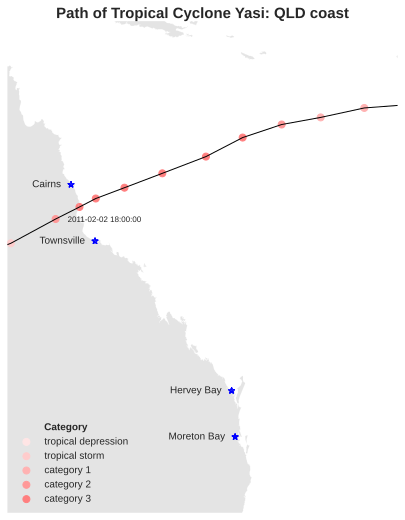

In [7]:
# TC Yasi at QLD coast
cycPlot(Yasi, 'QLD coast', 'Yasi', timeoffset=12, timePlot_interval=12, timePlot=True)

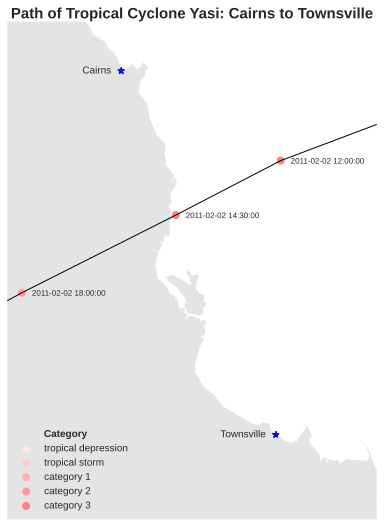

In [8]:
# TC Yasi between Cairns and Townsville
cycPlot(Yasi, 'Cairns to Townsville', 'Yasi', timePlot=True)

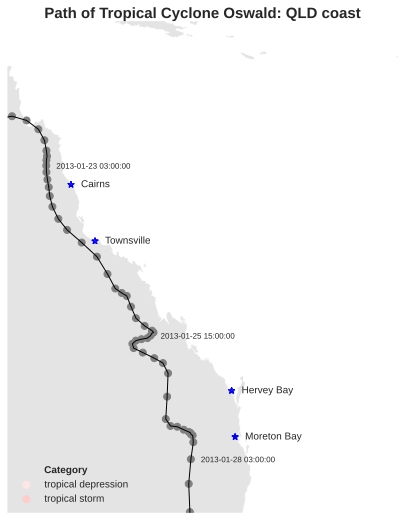

In [9]:
# TC Oswald at QLD coast
cycPlot(Oswald, 'QLD coast', 'Oswald', cityalign='left', cityoffset=+10, timePlot_interval=20, timePlot=True)

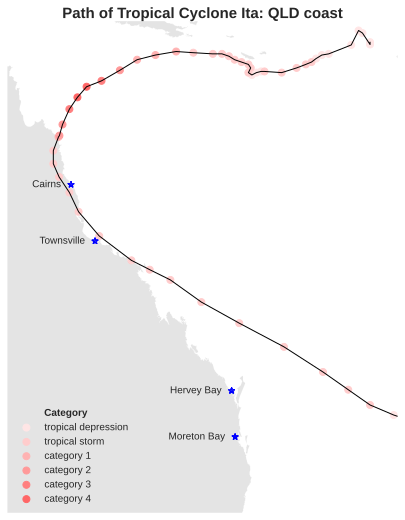

In [13]:
# TC Ita at the QLD coast
cycPlot(Ita, 'QLD coast', 'Ita')

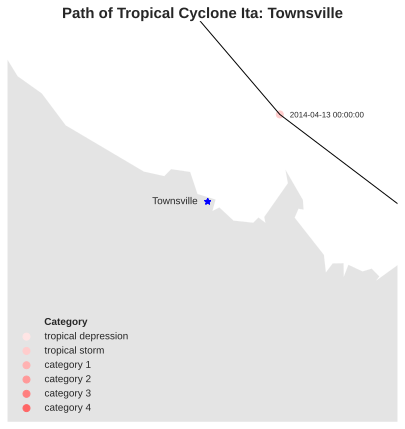

In [11]:
# TC Ita at Townsville
cycPlot(Ita, 'Townsville', 'Ita', timePlot=True)